In [155]:
# Load necessary libraries
library(mclust)
library(dplyr)
library(ggplot2)
library(randomForest)
library(purrr)
library(tidyr) # for pivot functions

# Load the data
mimic_unscaled <- read.csv('/Users/rishabhgoel/Desktop/Gen1E-RIDGE/MIMIC-IV Project and eICU-CRD/mice_filled_baseline_preprocessed_out.csv')  # Replace with the correct path to your data file
mimic_scaled <- read.csv('/Users/rishabhgoel/Desktop/Gen1E-RIDGE/MIMIC-IV Project and eICU-CRD/mice_filled_baseline_preprocessed_scaled_out.csv')

# mimic_scaled <- subset(mimic_scaled, select = -c(PEEP, PaO2.FiO2, Tidal.Volume..observed., Height,
#                                                   anchor_age,Total.Minute.Ventilation, Peak.Insp..Pressure,PCO2,
#                                                  Anion.gap, TCO2..calc..Arterial, SpO2.FiO2, Respiratory.Rate))

# Conduct initial LPA

mimic_scaled <- subset(mimic_scaled, select = -c(anchor_age))

model <- Mclust(mimic_scaled, G=2)
summary(model)

mimic_unscaled$cluster <- model$classification

cluster_stats <- mimic_unscaled %>%
  group_by(cluster) %>%
  summarise(
    mortality_30_day = mean(mortality_30d, na.rm = TRUE),
#     sd_mortality_30_day = sd(mortality_30d, na.rm = TRUE),
    mortality_90_day = mean(mortality_90d, na.rm = TRUE),
#     sd_mortality_90_day = sd(mortality_90d, na.rm = TRUE),
    in_hospital_mortality = mean(hospital_expire_flag, na.rm = TRUE),
#     sd_in_hospital_mortality = sd(hospital_expire_flag, na.rm = TRUE),
    duration_till_death = median(time_until_death, na.rm = TRUE),
#       sd_duration_till_death = sd(time_until_death, na.rm = TRUE)
  )

# Print column names
print(names(mimic_scaled))

# write.csv(mimic_unscaled,'/Users/rishabhgoel/Desktop/Gen1E-RIDGE/MIMIC-IV Project and eICU-CRD/checking_lpa_no_ventilator.csv')


mimic_unscaled <- subset(mimic_unscaled, select = -c(cluster))

cluster_stats


# # Filter out patients from third cluster
# mimic_scaled <- mimic_scaled %>% filter(model$classification < 3)
# mimic_unscaled <- mimic_unscaled %>% filter(model$classification < 3)


# # Conduct LPA for each number of clusters from 1 to 5
# for (n_clusters in 1:5) {
#   model <- Mclust(mimic_scaled, G=n_clusters)
#   print(paste("Number of clusters:", n_clusters))
#   print(summary(model))
    
#   # Extract log-likelihood and number of parameters
#   logLikelihood <- model$loglik
#   numParameters <- length(model$parameters$mean[[1]]) + length(model$parameters$variance$sigma)

#   # Calculate AIC
#   aic <- 2*numParameters - 2*logLikelihood

#   # Calculate entropy
#   epsilon <- 1e-10  # small constant to avoid log(0)
#   entropy <- -sum(sapply(model$z, function(x) sum(x * log(x + epsilon))))

#   print(paste("Number of clusters:", n_clusters, "AIC:", aic, "Entropy:", entropy))
#                          }


---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VEV (ellipsoidal, equal shape) model with 2 components: 

 log-likelihood    n df       BIC       ICL
      -15335.37 1417 82 -31265.76 -31550.42

Clustering table:
   1    2 
1015  402 

[1] "Heart.Rate"         "SpO2"               "Hematocrit..serum."
[4] "White.Blood.Cells"  "Creatinine..serum." "Glucose..serum."   
[7] "Sodium"             "Platelets"         


cluster,mortality_30_day,mortality_90_day,in_hospital_mortality,duration_till_death
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.2275862,0.3142857,0.2384236,33
2,0.3905473,0.5049751,0.4179104,20


----------------------------------------------------------------- 
Dimension reduction for model-based clustering and classification 
----------------------------------------------------------------- 

Mixture model type: Mclust (VEV, 2) 
        
Clusters    n
       1 1015
       2  402

Estimated basis vectors: 
                        Dir1
Heart.Rate         -0.079362
SpO2                0.614718
Hematocrit..serum.  0.250377
White.Blood.Cells   0.295640
Creatinine..serum. -0.388273
Glucose..serum.    -0.026921
Sodium              0.230973
Platelets           0.510786

                 Dir1
Eigenvalues   0.45631
Cum. %      100.00000

[1] "Number of clusters: 1"
---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust XXX (ellipsoidal multivariate normal) model with 1 component: 

 log-likelihood    n df       BIC       ICL
      -15853.14 1417 44 -32025.55 -32025.55

Clustering table:
   1 
1417 
[1] "Number of clusters: 2"
---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VEV (ellipsoidal, equal shape) model with 2 components: 

 log-likelihood    n df       BIC       ICL
      -15335.37 1417 82 -31265.76 -31550.42

Clustering table:
   1    2 
1015  402 
[1] "Number of clusters: 3"
---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VEV (ellipsoidal, equal shape) model

          Length Class  Mode     
G            8   -none- numeric  
modelName    1   -none- character
obs          8   -none- numeric  
boot      7992   -none- numeric  
p.value      8   -none- numeric  

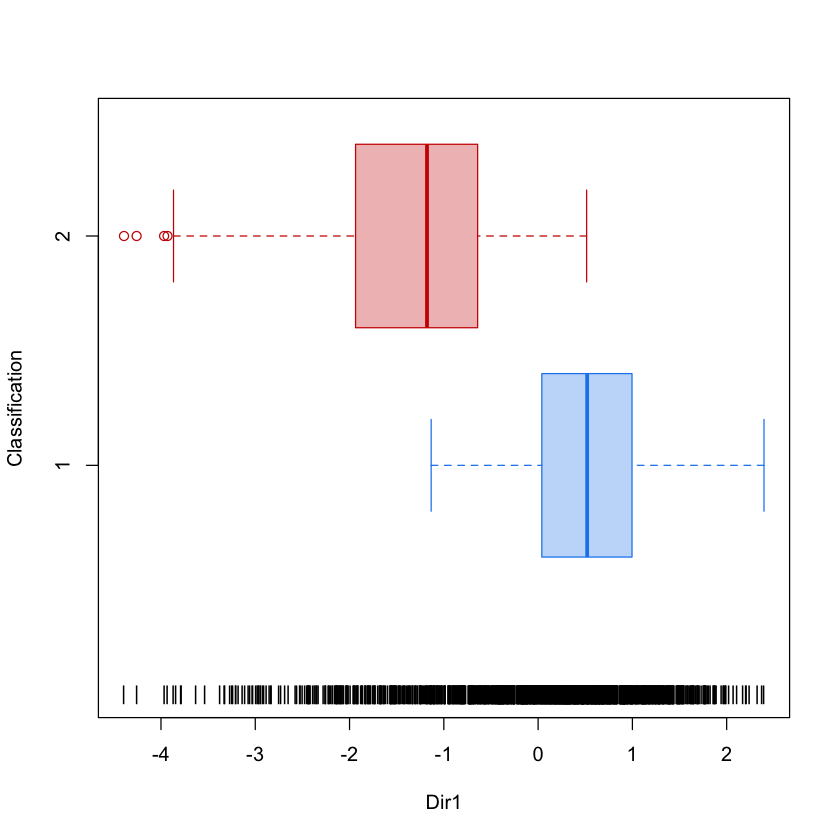

In [156]:
mod <- Mclust(mimic_scaled, G=2)
drmod <- MclustDR(mod, lambda = 1)
summary(drmod)
plot(drmod, what = 'boundaries')
# table(Class, mod$classification)
# adjustedRandIndex(cluster, mod$classification)





# Define the number of clusters
n_clusters <- 1:5

# Store the results
results <- data.frame()

# Conduct LPA for each number of clusters
for (n in n_clusters) {
  model <- Mclust(mimic_scaled, G = n)
  print(paste("Number of clusters:", n))
  print(summary(model))
  
  # Extract log-likelihood and number of parameters
  logLikelihood <- model$loglik
  numParameters <- length(model$parameters$mean[[1]]) + length(model$parameters$variance$sigma)
  
  # Calculate AIC
  aic <- 2 * numParameters - 2 * logLikelihood
  
  # Calculate entropy
  epsilon <- 1e-10
  entropy <- -sum(sapply(model$z, function(x) sum(x * log(x + epsilon))))
  
#   # Perform BLRT for k > 1
#   blrt_p_value <- NA
#   if (n > 1) {
#     blrt_result <- mclustBootstrapLRT(model, nboot = 100)
#     blrt_p_value <- blrt_result$p.value
#   }
  
  # Store the results
  result <- data.frame(
    "Number of clusters" = n,
#     "Model" = model$modelName,
    "AIC" = aic,
    "Entropy" = entropy
#     "BLRT p-value" = blrt_p_value
  )
  results <- rbind(results, result)
}

# Print the results
print(results)

LRT <- mclustBootstrapLRT(mimic_scaled, modelName = 'VEV')
summary(LRT)
                         
# mod1 <- Mclust(mimic_scaled, x = BIC)
# summary(mod1, parameters = TRUE)                         
# plot(mod1, what = "classification")

In [157]:
LRT <- mclustBootstrapLRT(mimic_scaled, modelName = 'VEV')
LRT

------------------------------------------------------------- 
Bootstrap sequential LRT for the number of mixture components 
------------------------------------------------------------- 
Model        = VEV 
Replications = 999 
              LRTS bootstrap p-value
1 vs 2   1035.5321             0.001
2 vs 3    303.5461             0.001
3 vs 4    205.1953             0.001
4 vs 5    190.6038             0.001
5 vs 6    104.2470             0.003
6 vs 7    132.5642             0.001
7 vs 8    110.4897             0.001
8 vs 9    107.1497             0.022

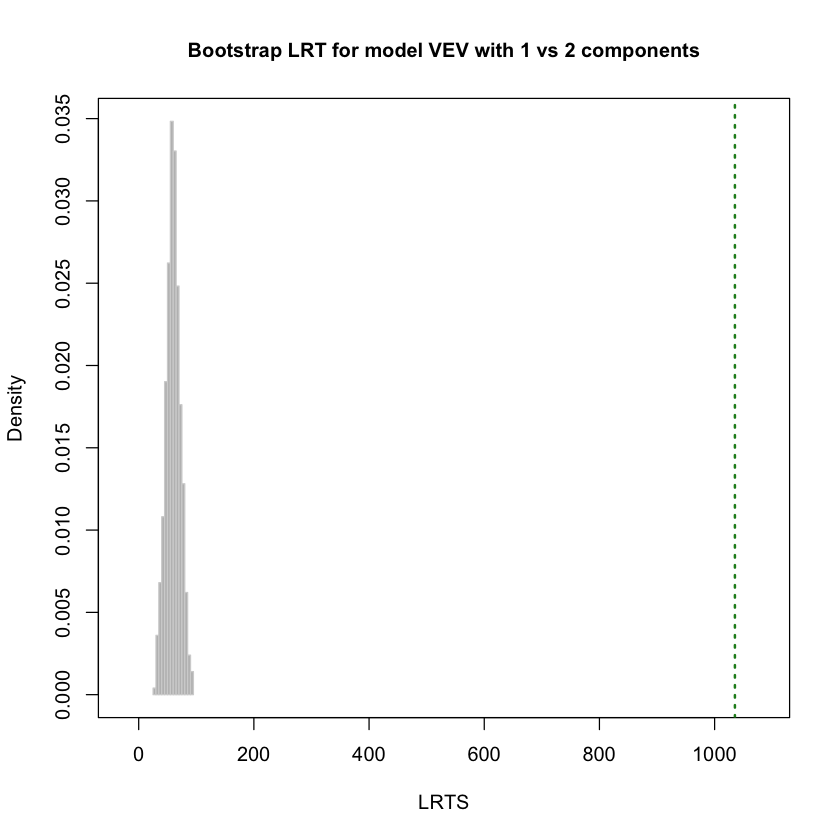

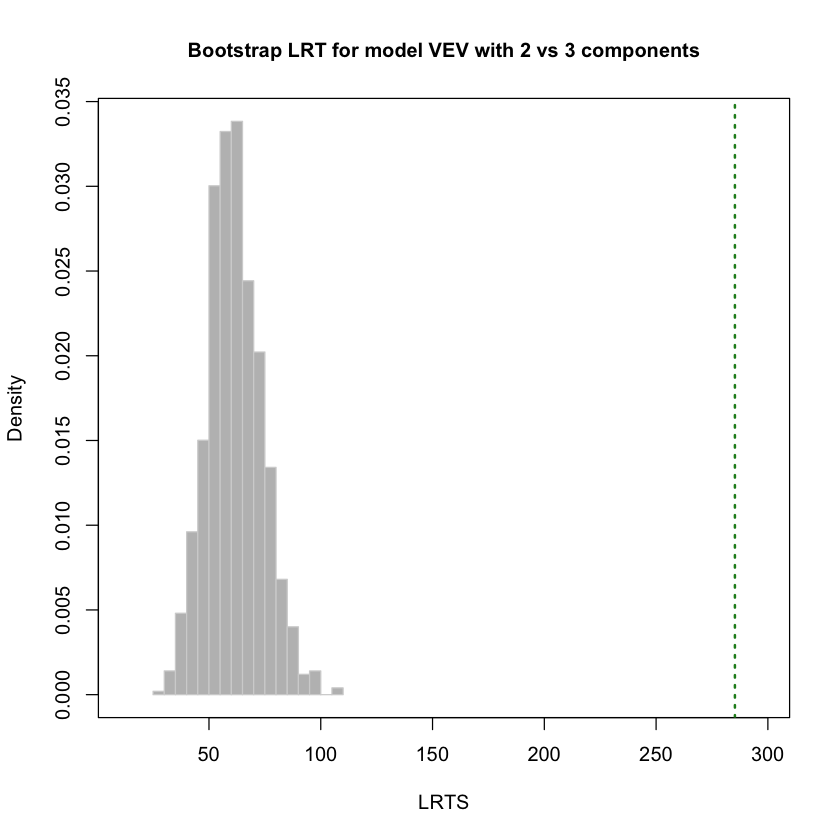

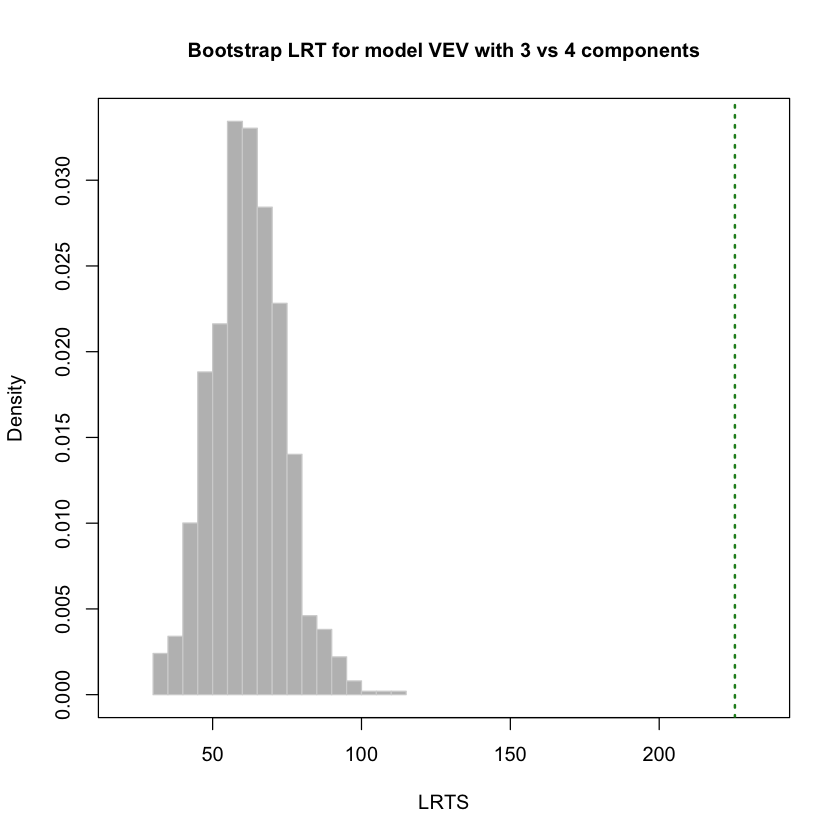

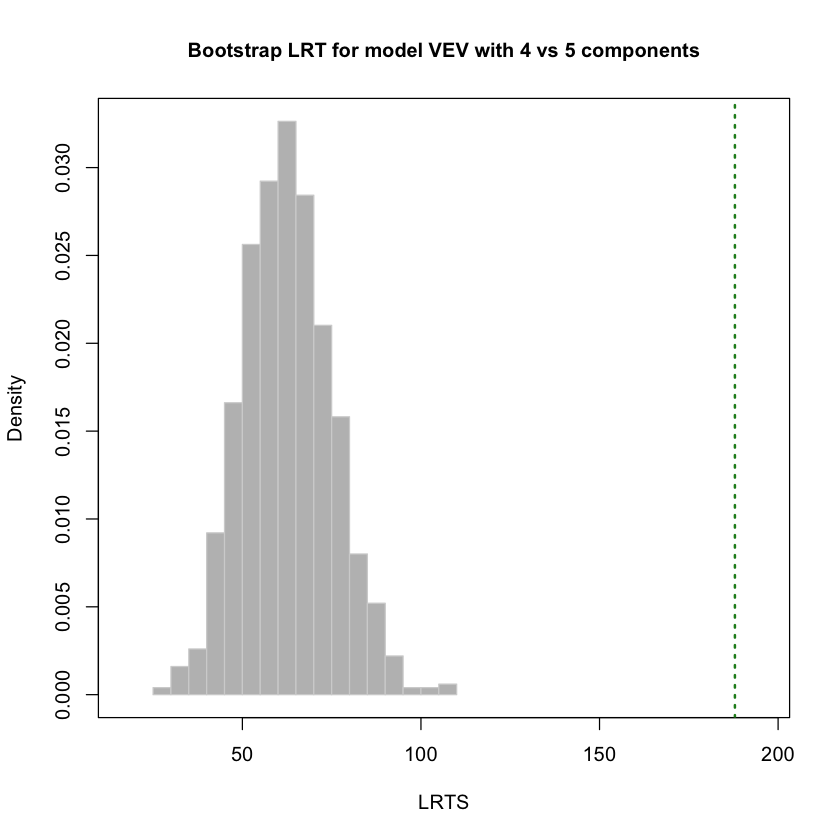

In [148]:
plot(LRT, G = 1)
plot(LRT, G = 2)
plot(LRT, G = 3)
plot(LRT, G = 4)

In [151]:
TRY <- mclustBootstrapLRT(mimic_scaled, modelName = 'VVE', maxG = 2)
TRY

------------------------------------------------------------- 
Bootstrap sequential LRT for the number of mixture components 
------------------------------------------------------------- 
Model        = VVE 
Replications = 999 
             LRTS bootstrap p-value
1 vs 2   829.6719             0.001
2 vs 3   290.9858             0.001

In [191]:
# Load necessary libraries
library(mclust)
library(dplyr)
library(ggplot2)
library(randomForest)
library(purrr)
library(tidyr) # for pivot functions

# Load the data
mimic_unscaled <- read.csv('/Users/rishabhgoel/Desktop/Gen1E-RIDGE/MIMIC-IV Project and eICU-CRD/longitudinal/mice_filled_baseline_preprocessed_out.csv')  # Replace with the correct path to your data file
mimic_scaled <- read.csv('/Users/rishabhgoel/Desktop/Gen1E-RIDGE/MIMIC-IV Project and eICU-CRD/longitudinal/mice_filled_baseline_preprocessed_scaled_out.csv')

# mimic_scaled <- subset(mimic_scaled, select = -c(PEEP, PaO2.FiO2, Tidal.Volume..observed., Height,
#                                                   anchor_age,Total.Minute.Ventilation, Peak.Insp..Pressure,PCO2,
#                                                  Anion.gap, TCO2..calc..Arterial, SpO2.FiO2, Respiratory.Rate))

# Conduct initial LPA

# mimic_scaled <- subset(mimic_scaled, select = -c(anchor_age))

model <- Mclust(mimic_scaled, G=2)
summary(model)

mimic_unscaled$cluster <- model$classification

cluster_stats <- mimic_unscaled %>%
  group_by(cluster) %>%
  summarise(
    mortality_30_day = mean(mortality_30d, na.rm = TRUE),
#     sd_mortality_30_day = sd(mortality_30d, na.rm = TRUE),
    mortality_90_day = mean(mortality_90d, na.rm = TRUE),
#     sd_mortality_90_day = sd(mortality_90d, na.rm = TRUE),
    in_hospital_mortality = mean(hospital_expire_flag, na.rm = TRUE),
#     sd_in_hospital_mortality = sd(hospital_expire_flag, na.rm = TRUE),
    duration_till_death = median(time_until_death, na.rm = TRUE),
#       sd_duration_till_death = sd(time_until_death, na.rm = TRUE)
  )

# Print column names
print(names(mimic_scaled))

# write.csv(mimic_unscaled,'/Users/rishabhgoel/Desktop/Gen1E-RIDGE/MIMIC-IV Project and eICU-CRD/checking_lpa_no_ventilator.csv')


mimic_unscaled <- subset(mimic_unscaled, select = -c(cluster))
mimic_unscaled$cluster <- model$classification

cluster_stats


# # Filter out patients from third cluster
# mimic_scaled <- mimic_scaled %>% filter(model$classification < 3)
# mimic_unscaled <- mimic_unscaled %>% filter(model$classification < 3)


# # Conduct LPA for each number of clusters from 1 to 5
# for (n_clusters in 1:5) {
#   model <- Mclust(mimic_scaled, G=n_clusters)
#   print(paste("Number of clusters:", n_clusters))
#   print(summary(model))
    
#   # Extract log-likelihood and number of parameters
#   logLikelihood <- model$loglik
#   numParameters <- length(model$parameters$mean[[1]]) + length(model$parameters$variance$sigma)

#   # Calculate AIC
#   aic <- 2*numParameters - 2*logLikelihood

#   # Calculate entropy
#   epsilon <- 1e-10  # small constant to avoid log(0)
#   entropy <- -sum(sapply(model$z, function(x) sum(x * log(x + epsilon))))

#   print(paste("Number of clusters:", n_clusters, "AIC:", aic, "Entropy:", entropy))
#                          }



---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VEV (ellipsoidal, equal shape) model with 2 components: 

 log-likelihood    n df       BIC      ICL
      -14828.72 1368 82 -30249.57 -30539.5

Clustering table:
  1   2 
391 977 

[1] "Heart.Rate"         "SpO2"               "Hematocrit..serum."
[4] "White.Blood.Cells"  "Creatinine..serum." "Glucose..serum."   
[7] "Sodium"             "Platelets"         


cluster,mortality_30_day,mortality_90_day,in_hospital_mortality,duration_till_death
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3503836,0.4731458,0.3836317,25.0
2,0.2272262,0.3132037,0.2364381,33.5


In [192]:
# Load the data for Day 1
mimic_unscaled_day2 <- read.csv('/Users/rishabhgoel/Desktop/Gen1E-RIDGE/MIMIC-IV Project and eICU-CRD/longitudinal/mice_filled_baseline_preprocessed_out_day3.csv')  # Replace with the correct pa
mimic_scaled_day2 <- read.csv('/Users/rishabhgoel/Desktop/Gen1E-RIDGE/MIMIC-IV Project and eICU-CRD/longitudinal/mice_filled_baseline_preprocessed_scaled_out_day3.csv')

# Conduct LPA for Day 1
model_day2 <- Mclust(mimic_scaled_day2, G=2)

# Add the Day 1 cluster classification to the original dataset
mimic_unscaled_day2$cluster <- model_day2$classification

# Find the patient IDs that were in Cluster 2 on Day 0
cluster2_day0_patients <- mimic_unscaled %>% filter(cluster == 2)

# Check how many of these patients are now in Cluster 1 on Day 2
cluster1_day2_patients <- mimic_unscaled_day2 %>% 
    semi_join(cluster2_day0_patients, by = "subject_id") %>%
    filter(cluster == 1)

# Print the count
print(nrow(cluster1_day2_patients))


[1] 73


In [193]:
# Identify patients present on Day 0 but not on Day 1
missing_day1_patients <- mimic_unscaled %>% 
    anti_join(mimic_unscaled_day2, by = "subject_id")

# Print a count of these patients
print(nrow(missing_day1_patients))

[1] 110


In [194]:
# Group by cluster and count
missing_day1_clusters <- missing_day1_patients %>% 
    group_by(cluster) %>% 
    summarise(count = n())

# Print the results
print(missing_day1_clusters)

# A tibble: 2 × 2
  cluster count
    <dbl> <int>
1       1    30
2       2    80


In [195]:
# Calculate mortality rate for each cluster among patients missing on Day 1
missing_day1_mortality <- missing_day1_patients %>% 
    group_by(cluster) %>% 
    summarise(
        count = n(),
        mortality_rate = mean(hospital_expire_flag, na.rm = TRUE)
    )

# Print the results
print(missing_day1_mortality)

# A tibble: 2 × 3
  cluster count mortality_rate
    <dbl> <int>          <dbl>
1       1    30          0.633
2       2    80          0.262
